In [ ]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder
import optuna 


In [33]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/e8/30/35111dae435c640694d616a611b7ff6b2482cfd977f8f572ff960a321d66/optuna-4.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/cb/06/8b505aea3d77021b18dcbd8133aa1418f1a1e37e432a465b14c46b2c0eaa/alembic-1.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy>=1.4.2 from https://files.pythonhosted.org/packages/b1/03/d12b7c1d36fd80150c1d52e121614cf9377dac99e5497af8d8f5b2a8db64/SQLAlchemy-2.0.36-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/48/22/bc14c6f02e6dccaafb3eba95764c8f096714260c2aa5f76f654fd16a23dd/Mako-1.3.6-py3-no


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\defaultuser0.LAPTOP-LRB3T941\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
data=pd.read_csv("Silver nanomaterils antibacterial  .csv")
data.head()

,Process,Steps,External_energy,Temp_Celcius,Stirring,Synthesis_Duration_h,Scale_synthesis_ml,Precurcor_conc_mM,NEW_Capping agent,NEW_capping agent_Class,...,treatment,UVVIs PEAKS nm,shape,core size (nm),Method of determination_size,exposure dose concentration mg/mL,Exposure duration (h),bacterial Culture medium,bacterial Species,Bacteria reduction mm
0,phytosynthesis,single,No,25,No,4,?,7,plant,organic,...,no,430,spherical,25,SEM,0.01125,?,MuellerHinton,Enterococcus,6.0
1,phytosynthesis,single,No,25,No,4,?,7,plant,organic,...,no,430,spherical,25,SEM,0.0225,?,MuellerHinton,Enterococcus,6.0
2,phytosynthesis,single,No,25,No,4,?,7,plant,organic,...,no,430,spherical,25,SEM,0.01125,?,MuellerHinton,Enterococcus,6.0
3,phytosynthesis,single,Heating,80,Stirring,2,20,1.5,plant,organic,...,no,420,spherical,10,TEM,0.08,24,MuellerHinton,Salmonella,0.0
4,phytosynthesis,single,Heating,80,Stirring,2,20,1.5,plant,organic,...,no,420,spherical,10,TEM,0.04,24,MuellerHinton,Salmonella,0.0


In [9]:
# Count the number of "?" in each column
missing_values = (data == '?').sum()/len(data) *100
print(missing_values)

Process                               0.000000
Steps                                 0.000000
External_energy                       0.000000
Temp_Celcius                          3.756994
Stirring                              0.000000
Synthesis_Duration_h                 11.350919
Scale_synthesis_ml                   40.607514
Precurcor_conc_mM                     2.398082
NEW_Capping agent                     0.000000
NEW_capping agent_Class               0.959233
NEW_reducing agent                    1.438849
NEW_reducing agent_class              1.438849
Capping agent concentration_mg/mL    34.052758
Reducing agent quantity mL           41.646683
Order of reagent_CODE                 7.114309
treatment                             0.159872
UVVIs PEAKS nm                        6.075140
shape                                 9.192646
core size (nm)                        9.352518
Method of determination_size         10.311751
exposure dose concentration mg/mL    16.227018
Exposure dura

In [18]:

categorical_cols = ['Process',"NEW_Capping agent", "NEW_reducing agent_class" ,"Order of reagent_CODE",'Steps', 'External_energy', 'Stirring', 'NEW_Capping agent', 'NEW_capping agent_Class', 'treatment', 'shape', 'Method of determination_size', 'bacterial  Culture medium', 'bacterial  Species']
data.replace('?', np.nan, inplace=True)

for col in categorical_cols:
    data[col] = data[col].astype('category')
object_cols = data.select_dtypes(['object']).columns

# Convert object columns to numeric
for cols in object_cols:
    try:
        data[cols] = pd.to_numeric(data[cols])
    except:
        pass
        #print(cols)
#data["Temp_Celcius"] = pd.to_numeric(data["Temp_Celcius"])
print(data.dtypes)

Process                              category
Steps                                category
External_energy                      category
Temp_Celcius                          float64
Stirring                             category
Synthesis_Duration_h                  float64
Scale_synthesis_ml                    float64
Precurcor_conc_mM                     float64
NEW_Capping agent                    category
NEW_capping agent_Class              category
NEW_reducing agent                   category
NEW_reducing agent_class             category
Capping agent concentration_mg/mL     float64
Reducing agent quantity mL            float64
Order of reagent_CODE                category
treatment                            category
UVVIs PEAKS nm                        float64
shape                                category
core size (nm)                        float64
Method of determination_size         category
exposure dose concentration mg/mL     float64
Exposure duration  (h)            

#convert the numerical datas to number ,and the categorical data


In [20]:
data2=data.copy()
categoricical_COLS=[i for i in data.columns if data[i].dtype.name == 'category']
label_encoder = LabelEncoder()
encoded_cols=[]
for col in categoricical_COLS:
    data2[col + '_encoded'] = label_encoder.fit_transform(data[col].astype(str))
    encoded_cols.append(col + '_encoded')
    
data2.drop(categoricical_COLS, axis=1, inplace=True)
data2.head()

,Temp_Celcius,Synthesis_Duration_h,Scale_synthesis_ml,Precurcor_conc_mM,Capping agent concentration_mg/mL,Reducing agent quantity mL,UVVIs PEAKS nm,core size (nm),exposure dose concentration mg/mL,Exposure duration (h),...,NEW_Capping agent_encoded,NEW_capping agent_Class_encoded,NEW_reducing agent_encoded,NEW_reducing agent_class_encoded,Order of reagent_CODE_encoded,treatment_encoded,shape_encoded,Method of determination_size_encoded,bacterial Culture medium_encoded,bacterial Species_encoded
0,25.0,4.0,NaN,7.0,91.0,NaN,430.0,25.0,0.01125,NaN,...,8,3,7,2,3,4,7,5,4,11
1,25.0,4.0,NaN,7.0,91.0,NaN,430.0,25.0,0.02250,NaN,...,8,3,7,2,3,4,7,5,4,11
2,25.0,4.0,NaN,7.0,91.0,NaN,430.0,25.0,0.01125,NaN,...,8,3,7,2,3,4,7,5,4,11
3,80.0,2.0,20.0,1.5,NaN,10.0,420.0,10.0,0.08000,24.0,...,8,3,7,2,3,4,7,6,4,29
4,80.0,2.0,20.0,1.5,NaN,10.0,420.0,10.0,0.04000,24.0,...,8,3,7,2,3,4,7,6,4,29


In [28]:
from sklearn.impute import  KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_impoted = imputer.fit_transform(data2)
data_impoted = pd.DataFrame(data_impoted, columns=data2.columns)
for cols in data_impoted:
    if cols in encoded_cols:
        data_impoted[cols]=label_encoder.inverse_transform(data_impoted[cols].astype(int))
data_impoted.head()

,Temp_Celcius,Synthesis_Duration_h,Scale_synthesis_ml,Precurcor_conc_mM,Capping agent concentration_mg/mL,Reducing agent quantity mL,UVVIs PEAKS nm,core size (nm),exposure dose concentration mg/mL,Exposure duration (h),...,NEW_Capping agent_encoded,NEW_capping agent_Class_encoded,NEW_reducing agent_encoded,NEW_reducing agent_class_encoded,Order of reagent_CODE_encoded,treatment_encoded,shape_encoded,Method of determination_size_encoded,bacterial Culture medium_encoded,bacterial Species_encoded
0,25.0,4.0,52.0,7.0,91.0,8.2,430.0,25.0,0.01125,24.0,...,Candida,Agrobacterium tumefaciens,Campylobacter,Aeromonas,Agrobacterium tumefaciens,Aspergillus,Campylobacter,Bacillus,Aspergillus,Enterococcus
1,25.0,4.0,52.0,7.0,91.0,8.2,430.0,25.0,0.02250,24.0,...,Candida,Agrobacterium tumefaciens,Campylobacter,Aeromonas,Agrobacterium tumefaciens,Aspergillus,Campylobacter,Bacillus,Aspergillus,Enterococcus
2,25.0,4.0,52.0,7.0,91.0,8.2,430.0,25.0,0.01125,24.0,...,Candida,Agrobacterium tumefaciens,Campylobacter,Aeromonas,Agrobacterium tumefaciens,Aspergillus,Campylobacter,Bacillus,Aspergillus,Enterococcus
3,80.0,2.0,20.0,1.5,40.0,10.0,420.0,10.0,0.08000,24.0,...,Candida,Agrobacterium tumefaciens,Campylobacter,Aeromonas,Agrobacterium tumefaciens,Aspergillus,Campylobacter,Calcateuticals anitratus,Aspergillus,Salmonella
4,80.0,2.0,20.0,1.5,40.0,10.0,420.0,10.0,0.04000,24.0,...,Candida,Agrobacterium tumefaciens,Campylobacter,Aeromonas,Agrobacterium tumefaciens,Aspergillus,Campylobacter,Calcateuticals anitratus,Aspergillus,Salmonella


In [46]:
for cols in data_impoted:
    if cols in encoded_cols:
        data_impoted[cols]=data_impoted[cols].astype('category')

In [47]:
data_impoted.dtypes

Temp_Celcius                             float64
Synthesis_Duration_h                     float64
Scale_synthesis_ml                       float64
Precurcor_conc_mM                        float64
Capping agent concentration_mg/mL        float64
Reducing agent quantity mL               float64
UVVIs PEAKS nm                           float64
core size (nm)                           float64
exposure dose concentration mg/mL        float64
Exposure duration  (h)                   float64
Bacteria reduction mm                    float64
Process_encoded                         category
Steps_encoded                           category
External_energy_encoded                 category
Stirring_encoded                        category
NEW_Capping agent_encoded               category
NEW_capping agent_Class_encoded         category
NEW_reducing agent_encoded              category
NEW_reducing agent_class_encoded        category
Order of reagent_CODE_encoded           category
treatment_encoded   

In [ ]:

X = data_impoted.drop('Bacteria reduction mm', axis=1)
y = data_impoted['Bacteria reduction mm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=666)


MAking and ensemble model, or i should train optuna first

In [ ]:

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10)
    }
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=encoded_cols)
    #lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=categorical_cols)
    
    gbm = lgb.train(param, lgb_train)
    
    preds = gbm.predict(X_train, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(y_train, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000,n_jobs=-1)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2024-11-25 23:37:23,403] A new study created in memory with name: no-name-a4903090-de8e-4589-8b9a-34a472bf758d
[I 2024-11-25 23:37:23,740] Trial 4 finished with value: 4.749859010024858 and parameters: {'learning_rate': 0.055753362715379534, 'num_leaves': 146, 'max_depth': 12, 'min_data_in_leaf': 65, 'feature_fraction': 0.8483837111125199, 'bagging_fraction': 0.5084657135288058, 'bagging_freq': 1}. Best is trial 4 with value: 4.749859010024858.
[I 2024-11-25 23:37:23,770] Trial 7 finished with value: 5.72688621721878 and parameters: {'learning_rate': 0.015928478423680066, 'num_leaves': 65, 'max_depth': 12, 'min_data_in_leaf': 73, 'feature_fraction': 0.5463287804520822, 'bagging_fraction': 0.6325278876795383, 'bagging_freq': 10}. Best is trial 4 with value: 4.749859010024858.
[I 2024-11-25 23:37:23,817] Trial 3 finished with value: 4.106846696835475 and parameters: {'learning_rate': 0.08613223260816506, 'num_leaves': 63, 'max_depth': 10, 'min_data_in_leaf': 76, 'feature_fraction': 0.

Best trial:
  Value: 1.9901206348711666
  Params: 
    learning_rate: 0.09996854381635491
    num_leaves: 133
    max_depth: 12
    min_data_in_leaf: 10
    feature_fraction: 0.981296099300447
    bagging_fraction: 0.973664423731127
    bagging_freq: 1


In [111]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

params=trial.params
model=lgb.LGBMRegressor(**params)
#model2=lgb.LGBMRegressor()
tests=[]
y_preds=[]
y_rmse=[]
for i in range(1 , 10):
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=i/10, random_state=666)
    tests.append(f"{i*10}")
    y_predss = model.fit(X_train2, y_train2).predict(X_test2)
    r2=r2_score(y_test2 , y_predss)
    msse=mean_squared_error(y_test2,y_predss)
    y_rmse.append(msse)
    y_preds.append(r2)
#y_predss2 = model2.fit(X_train2, y_train2).predict(X_test2)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.981296099300447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981296099300447
[LightGBM] [Warning] bagging_fraction is set=0.973664423731127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.973664423731127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.981296099300447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981296099300447
[LightGBM] [Warning] bagging_fraction is set=0.973664423731127, subsample=1.0 will be ignored. Current value: bagging_f

Text(0, 0.5, 'R2 score')

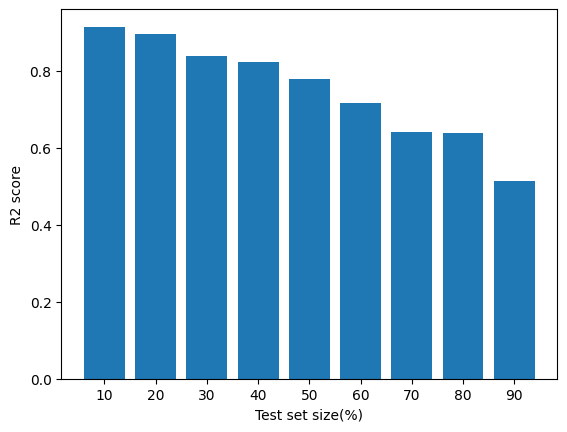

In [110]:

plt.bar(x=tests ,height=y_preds )
plt.xlabel("Test set size(%)")
plt.ylabel("R2 score")
#print(f'R² value: {r2}')

Text(0, 0.5, 'Rmse')

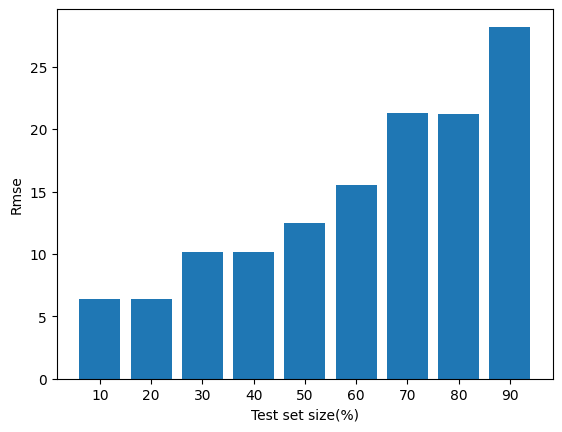

In [112]:

plt.bar(x=tests ,height=y_rmse )
plt.xlabel("Test set size(%)")
plt.ylabel("Rmse")


[6.35498169977489,
 6.418235869027035,
 10.122229519275214,
 10.160319080618123,
 12.437293282479802,
 15.515729693095723,
 21.3227850806801,
 21.17420236743794,
 28.202816887187552]